# Setup

### Imports

In [1]:
import copy
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow_gan.examples.mnist.util import mnist_frechet_distance

from src.sarnet_vae import *
from src.semidense import *

2024-06-07 13:40:41.804077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 13:40:41.804109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 13:40:41.805253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 13:40:41.812145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 13:40:42.738763: W tensorflow/compiler/tf2

### Config
- set a particural digit to reconstruct

In [2]:
DIGIT = 5
image_dim = 28
n_pixels = image_dim * image_dim

### Data loading

- Load images from the MNIST dataset and scale them to range [0-1]

In [3]:
# Load train images
images = np.load("./data/train_images.npy")
labels = np.load("./data/train_labels.npy")
images = images[labels == DIGIT]

# Load test images
test_images = np.load("./data/test_images.npy")
test_labels = np.load("./data/test_labels.npy")
test_images = test_images[test_labels == DIGIT]

# Raw data
raw_data = images
raw_test_data = test_images

# Standarized data
standarized_data = images / 255
standarized_test_data = test_images / 255

In [4]:
def prepare_dataset(train_data, test_data, batch_size=64, device="cuda"):
    """Create torch dataloader from the numpy data.

    Parameters
    ----------
    train_data : numpy.ndarray
        The training data.
    test_data : numpy.ndarray
        The testing data.
    batch_size : int, optional
        The batch size for the DataLoader (default is 64).
    device : str, optional
        The device on which the data will be moved (default is cuda).

    Returns
    -------
    train_loader : torch.utils.data.DataLoader
        DataLoader object for the training data with tensors of shape (1,image_dim,image_dim).
    test_loader : torch.utils.data.DataLoader
        DataLoader object for the testing data with tensors of shape (1,image_dim,image_dim).
    """
    X = train_data.reshape(-1, 1, image_dim, image_dim)
    X = torch.tensor(X).float().to(device)
    train_loader = DataLoader(TensorDataset(X), batch_size=64, shuffle=True)

    X_test = test_data.reshape(-1, 1, image_dim, image_dim)
    X_test = torch.tensor(X_test).float().to(device)
    test_loader = DataLoader(
        TensorDataset(X_test), batch_size=batch_size, shuffle=False
    )

    return train_loader, test_loader

### Image generation

 - the function below generates an image (or multiple images in parallel) using a `sarNET_VAE` model. It can generate an image from scratch (starting with a black patch) or continue generating from a part of existing image.

 - First, it generates a latent space random vector, which defines the style of the image. Next, it generates the image (or a batch of images) patch by patch. The random vector can be modified to have less variance, resulting in output digits that are "sharper" but less diverse.

- To stabilize generation process, it blacks out the pixels below a certain threshold - typically, the pixels below a small constant ~0.09 are set to black.

In [5]:
def get_i_patch(patch_idx, patch_dim, img_size):
    """
    Get the pixel indices of a specific patch in the image.
    """
    row = patch_idx // (img_size // patch_dim)
    col = patch_idx % (img_size // patch_dim)
    pxl_idxs = [
        (row * patch_dim + p_y) * img_size + col * patch_dim + p_x
        for p_y in range(patch_dim)
        for p_x in range(patch_dim)
    ]
    return pxl_idxs


def init_image(patch_dim, image=None, pixels_seed=0):
    """
    Initialize an image by setting specific patches to zero.
    One can use a specific image as a seed to further generation.
    """
    patch_size = patch_dim**2
    patches = n_pixels // patch_size

    if image is None:
        start_image = np.zeros(n_pixels)
        indexes_of_patches = list(range(patches - 1))
    else:
        start_image = copy.deepcopy(image).reshape(n_pixels)

        assert pixels_seed % patch_size == 0
        indexes_of_patches = list(
            range((pixels_seed // patch_size - 1), patches - 1)
        )
        for i_p in indexes_of_patches:
            idxs = get_i_patch(i_p + 1, patch_dim, image_dim)
            start_image[idxs] = 0

    return start_image, indexes_of_patches


def plot_image(image, show_plot=True):
    """
    Plot an image.
    """
    plt.imshow(image.reshape(28, 28), cmap="gray")
    if show_plot:
        plt.show()

In [6]:
def generate_image(
    model,
    patch_dim,
    latent_dim=10,
    image=None,
    pixels_seed=0,
    th=0,
    plot=True,
    num_of_images=1,
    cust_z=None,
    device="cuda",
):
    """
    Generate an image (or multiplie images - num_of_images) using a regression sarnet_vae model.

    Parameters
    ----------
    model : nn.Module
        The sarnet_vae model used for generating the image.
    patch_dim : int
        The dimension of the patches to process.
    latent_dim : int, optional
        The dimension of the latent space (default is 10).
    image : numpy.ndarray, optional
        The initial image to be used as a base for generation. If None, a blank image is used.
    pixels_seed : int, optional
        Only applicable if image is not None and num_of_images=1. It's the number of pixels from the base image used as a seed for generation.
    th : float, optional
        The threshold for pixel values (default is 0).
    plot : bool, optional
        Whether to plot the generated image (default is True).
    num_of_images : int, optional
        The number of images for parallel generation (default is 1).
    cust_z : torch.Tensor, optional
        Custom latent vector to be used for generation. If None, a random vector is generated.
    device : str, optional
        The device of the latent vector to be moved on
        
    Returns
    -------
    numpy.ndarray
        The generated image as a numpy array.
    """

    # Initialize the image and get the indexes of patches to process
    start_image, indexes_of_patches = init_image(patch_dim, image=image, pixels_seed=pixels_seed)
    start_image = start_image.reshape(1, image_dim * image_dim)
    start_image = np.repeat(start_image, num_of_images, axis=0)

    if cust_z is not None:
        z = cust_z
    else:
        z = torch.randn(num_of_images, latent_dim).to(device)

    min_pixel, min_th = 0, th

    # Iterate over the patches to generate the image
    for idx in indexes_of_patches:
        patch_idxs = get_i_patch(idx, patch_dim, image_dim)

        X = start_image.reshape(num_of_images, 1, image_dim, image_dim)
        X = torch.tensor(X).float().to("cuda")

        Y = model.decode(X, z)

        Y = Y.to("cpu").detach().numpy().reshape(num_of_images, -1)
        patch_idxs = get_i_patch(idx + 1, patch_dim, image_dim)

        Y = Y[:, patch_idxs]

        Y[Y < min_th] = min_pixel

        start_image[:, patch_idxs] = Y

    start_image = start_image.reshape(num_of_images, image_dim, image_dim)

    if plot:
        plot_image(start_image, show_plot=False)

    return start_image

### Losses and metrics

We calculate the Fréchet Inception Distance (FID) score between generated images and MNIST test images. We use `mnist_frechet_distance` function from the tensorflow_gan package. TF_GAN is widely used in projects and research at Google.

Unlike the traditional FID calculation, `mnist_frechet_distance` doesn't use the InceptionV3 model. Instead, it uses the TF-GAN MNIST classifier, which has ~99% accuracy. This approach allows for quicker calculations. The function expects the input pixel values to be in the range [-1,1].

In [7]:
def get_fid_score_mnist(generated_images, N):
    """
    Calculate the Fréchet Inception Distance (FID) score between generated images and MNIST test images.
    
    Parameters
    ----------
    generated_images : list, numpy.ndarray or torch.tensor
        The generated images to be evaluated. Should be a iterable list of images with shape (N, 28, 28).
    N : int
        The number of images to be used for calculating the FID score.

    Returns
    -------
    float
        The FID score between the generated images and the real MNIST test images.
    """

    # Select N real images from the standardized MNIST test data
    real_images = standarized_test_data.reshape(-1, 1, 28, 28)
    real_images = real_images[np.random.choice(real_images.shape[0], N)]

    # Scale images to [-1, 1] range -> this is the range of pixels the "mnist_frechet_distance" expects
    real_images = (
        real_images.reshape(-1, 1, 28, 28).transpose(0, 2, 3, 1) - 0.5
    ) * 2
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)

    # Prepare the generated images
    # Scale images to [-1, 1] range -> this is the range of pixels the "mnist_frechet_distance" expects
    gen_x = (
        np.array(generated_images).reshape(-1, 1, 28, 28).transpose(0, 2, 3, 1)
        - 0.5
    ) * 2
    gen_x = tf.convert_to_tensor(gen_x, dtype=tf.float32)

    # Calculate the number of batches for the FID computation
    num_batches = int(np.ceil(N / 500))
    num_batches = max(1, num_batches)
    score = mnist_frechet_distance(real_images, gen_x, num_batches)

    return score

In [8]:
# Define the loss function
def vae_loss_function(recon_x, x, mu, logvar, vae_model):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD + vae_model.decoder.loss(recon_x, x)

def compute_vae_error(model, test_loader, loss, loss_to_monitor):
    loss_sum = 0
    monitored_loss = 0
    with torch.no_grad():
        for x in test_loader:
            x = x[0].reshape(x[0].size(0), 1, image_dim, image_dim)

            recon_batch, mu, logvar = model(x)
            l = loss(recon_batch, x, mu, logvar, model)
            monitored_loss += loss_to_monitor(recon_batch, x)
            loss_sum += l

    print(f"Overall loss: {loss_sum / len(test_loader.dataset)}, Monitored loss: {monitored_loss / len(test_loader)}")
    return loss_sum / len(test_loader)

# Architecture

### SemiDense
The core of SarNET is a sparse linear layer. It is designed so that, except for the first neuron, each pixel/patch in the input is connected to the neurons corresponding to the subsequent pixel/patches. Additionaly, one can add connections from all the output neurons to the input latent vector.

The SemiDense layer takes a flattened image as input and processes it pixel by pixel or patch by patch (depending on the configuration). The patches are subsequent squares of the image and do not overlap. The layer can be configured in two ways:

- the 0-th output patch depends on the 0-th input patch, and the i-th output patch (for i>0) depends on the 0,...,(i-1)-th input patches (used in the first layer)
- the i-th output patch depends on the 0,...,i-th input patches (used in deeper layers)

The image below illustrates the second configuration. As shown, the last input patch is not connected to any neurons because we want to predict the last output patch based on the previous ones.



<img src="docs/SemiDense_graph.png" alt="SemiDense Graph" width="500">

The design allows us to feed the entire flattened image into a network and obtain an output image of the same size. There is no need to "shift" the sequence as in transformer models.

To preserve the autoregressive nature of the layer, the number of output pixels/patches should be the same as the number of input pixels/patches. The size of the input patches can vary the size of the output patches. For example, we can compress the image from patches of size 4x4 to patches of size 2x2 or 1x1. Conversely, we can expand the size of the patch to, for example, 8x8. Additionally, we can add channels to the input and output images—the architecture remains the same, but instead of looking at/predicting the patch in a single channel, we look at/predict the patch in every channel.



### sarNET VAE SemiDense Autoregressive Network Variational AutoEncoder

- The SarNET VAE leverages the advantages of a Variational AutoEncoder to enhance the generation process. First, it organizes the latent space using a convolutional encoder. Then, it feeds the input image into a stack of SemiDense layers. Each of the SemiDense layers has additional connections to the latent vector produced by the convolutional encoder.

- Within the stack of SemiDense layers, the first layer is of type 1, meaning that the 0-th output patch depends on the 0-th input patch, and the i-th output patch (for $i>0$) depends on the 0,...,(i-1)-th input patches. Subsequent layers are of type 2, where the i-th output patch depends on the 0-th to i-th input patches (used in deeper layers). We decided to use three SemiDense layers. The first one compresses the input patches, the second one generates the image, and the last one refines the output.

<img src="docs/sarNET_VAE.png" alt="SemiDense Graph" width="500">

- The loss function consists of the KLD loss and the reconstruction loss, which is BCE. We use BCE because we are dealing with black and white images, so we can interpret the output probability as the pixel intensity.



# Training (128 latent dim)

In [9]:
# config
patch_dim = 4
device="cuda"

In [10]:
latent_dim = 128
in_latent_dim = 128

hidden_channels_1 = 2
hidden_channels_2 = 2
hidden_img_size = image_dim // 2
hidden_patch_size = patch_dim // 2

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

layers = nn.Sequential(
    SemiDense(image_dim, hidden_img_size, 1, hidden_channels_1, patch_dim, hidden_patch_size, shift=True, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(hidden_img_size, image_dim, hidden_channels_1, hidden_channels_2, hidden_patch_size, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(image_dim, image_dim, hidden_channels_2, 1, patch_dim, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.Sigmoid()
)
custom_loss = nn.MSELoss(reduction="mean")
bce_loss = nn.BCELoss(reduction="sum")

sarnet_vae = sarNet_VAE(layers, bce_loss, latent_dim, image_dim)
sarnet_vae.to(device)
optimizer = torch.optim.Adam(sarnet_vae.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64, device=device
)

In [11]:
model = sarnet_vae
max_epochs = 200

for epoch in range(max_epochs):
    model.train()
    avg_loss = 0
    for x in train_loader:
        x = x[0].reshape(x[0].size(0), 1, 28, 28)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(x)
        loss = vae_loss_function(recon_batch, x, mu, logvar, model)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

    avg_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {avg_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

        '''if (epoch + 1) > 100:# == 0:
            model.eval()
            generated_images = []
            N = 10000
            num_of_images = 500
            for num in tqdm(range(0, N, num_of_images)):
                img = generate_image(
                    model,
                    patch_dim,
                    latent_dim=latent_dim,
                    th=0.105,
                    num_of_images=num_of_images,
                    plot=False,
                )

                generated_images.append(img)

            score = get_fid_score_mnist(generated_images, N)
            if score < 1.45:
                break
            print(f"FID", score)'''

After epoch 10 avg_los: 112.260611313
Overall loss: 112.05719757080078, Monitored loss: 0.018442098051309586
After epoch 20 avg_los: 101.449013025
Overall loss: 103.9395751953125, Monitored loss: 0.014558536000549793
After epoch 30 avg_los: 97.345225833
Overall loss: 101.3819351196289, Monitored loss: 0.01372595690190792
After epoch 40 avg_los: 94.967004762
Overall loss: 100.54206085205078, Monitored loss: 0.013403907418251038
After epoch 50 avg_los: 92.840517039
Overall loss: 100.0642318725586, Monitored loss: 0.01323026791214943
After epoch 60 avg_los: 91.151183891
Overall loss: 99.87970733642578, Monitored loss: 0.01326003484427929
After epoch 70 avg_los: 89.726038730
Overall loss: 99.88835906982422, Monitored loss: 0.013276314362883568
After epoch 80 avg_los: 88.594063361
Overall loss: 100.32568359375, Monitored loss: 0.013733494095504284
After epoch 90 avg_los: 87.439422591
Overall loss: 100.4602279663086, Monitored loss: 0.013658459298312664
After epoch 100 avg_los: 86.435334575


# Evaluation

Best score with vector 128 latent dim:
- mean FID: 1.5350 and std: 0.08037

Best score with vector 64 latent dim:
- mean FID: 1.5950 and std: 0.07689

Best score with vector 32 latent dim:
- mean FID: 1.5802 and std: 0.08526

Best score with vector 16 latent dim:
- mean FID: 1.6140 and std: 0.04884

Best score with vector 8 latent dim:
- mean FID: 2.1251 and std: 0.08887


### 64 latent dim

In [35]:
latent_dim = 64
in_latent_dim = 64

hidden_channels_1 = 1
hidden_channels_2 = 2
hidden_img_size = image_dim // 2
hidden_patch_size = patch_dim // 2

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

layers = nn.Sequential(
    SemiDense(image_dim, hidden_img_size, 1, hidden_channels_1, patch_dim, hidden_patch_size, shift=True, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(hidden_img_size, image_dim, hidden_channels_1, hidden_channels_2, hidden_patch_size, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(image_dim, image_dim, hidden_channels_2, 1, patch_dim, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.Sigmoid()
)
custom_loss = nn.MSELoss(reduction="mean")
bce_loss = nn.BCELoss(reduction="sum")

sarnet_vae = sarNet_VAE(layers, bce_loss, latent_dim, image_dim)
sarnet_vae.to(device)
optimizer = torch.optim.Adam(sarnet_vae.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64, device=device
)

model = sarnet_vae
max_epochs = 200

for epoch in range(max_epochs):
    model.train()
    avg_loss = 0
    for x in train_loader:
        x = x[0].reshape(x[0].size(0), 1, 28, 28)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(x)
        loss = vae_loss_function(recon_batch, x, mu, logvar, model)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

    avg_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {avg_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

        '''if (epoch + 1) > 50:# == 0:
            model.eval()
            generated_images = []
            N = 800
            num_of_images = 400
            for num in tqdm(range(0, N, num_of_images)):
                img = generate_image(
                    model,
                    patch_dim,
                    latent_dim=latent_dim,
                    th=0.105,
                    num_of_images=num_of_images,
                    plot=False,
                )

                generated_images.append(img)

            score = get_fid_score_mnist(generated_images, N)
            print(f"FID", score)
            if score < 1.45:
                break'''

After epoch 10 avg_los: 110.680290623
Overall loss: 110.40888214111328, Monitored loss: 0.01765618845820427
After epoch 20 avg_los: 101.688049620
Overall loss: 103.58287811279297, Monitored loss: 0.014414125122129917
After epoch 30 avg_los: 98.130812537
Overall loss: 101.11072540283203, Monitored loss: 0.013033402152359486
After epoch 40 avg_los: 95.726130604
Overall loss: 100.39429473876953, Monitored loss: 0.013002746738493443
After epoch 50 avg_los: 94.000004143
Overall loss: 99.6449203491211, Monitored loss: 0.012383217923343182
After epoch 60 avg_los: 92.579872851
Overall loss: 99.48002624511719, Monitored loss: 0.012343969196081161
After epoch 70 avg_los: 91.372130931
Overall loss: 99.21592712402344, Monitored loss: 0.012812693603336811
After epoch 80 avg_los: 90.300996432
Overall loss: 99.18836975097656, Monitored loss: 0.012853293679654598
After epoch 90 avg_los: 89.391624936
Overall loss: 99.16051483154297, Monitored loss: 0.012826468795537949
After epoch 100 avg_los: 88.51458

In [37]:
num_experiments = 10
N = 10000
num_of_images = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = sarnet_vae

for i in tqdm(range(num_experiments)):
    generated_images = []
    for num in range(0, N, num_of_images):
        img = generate_image(
            model,
            patch_dim,
            latent_dim=latent_dim,
            th=0.105,
            num_of_images=num_of_images,
            plot=False,
        )

        generated_images.append(img)
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:07<01:10,  7.79s/it]

FID in 0 tf.Tensor(1.4521933, shape=(), dtype=float32)


 20%|██        | 2/10 [00:15<01:00,  7.59s/it]

FID in 1 tf.Tensor(1.7141283, shape=(), dtype=float32)


 30%|███       | 3/10 [00:22<00:52,  7.52s/it]

FID in 2 tf.Tensor(1.6111147, shape=(), dtype=float32)


 40%|████      | 4/10 [00:30<00:45,  7.55s/it]

FID in 3 tf.Tensor(1.5877134, shape=(), dtype=float32)


 50%|█████     | 5/10 [00:38<00:38,  7.69s/it]

FID in 4 tf.Tensor(1.5936435, shape=(), dtype=float32)


 60%|██████    | 6/10 [00:46<00:31,  7.76s/it]

FID in 5 tf.Tensor(1.615664, shape=(), dtype=float32)


 70%|███████   | 7/10 [00:53<00:22,  7.63s/it]

FID in 6 tf.Tensor(1.6733835, shape=(), dtype=float32)


 80%|████████  | 8/10 [01:00<00:15,  7.53s/it]

FID in 7 tf.Tensor(1.4662293, shape=(), dtype=float32)


 90%|█████████ | 9/10 [01:08<00:07,  7.47s/it]

FID in 8 tf.Tensor(1.6195205, shape=(), dtype=float32)


100%|██████████| 10/10 [01:15<00:00,  7.57s/it]

FID in 9 tf.Tensor(1.6165888, shape=(), dtype=float32)
FID mean score: 1.5950178 FID std score: 0.076889604


### 32 latent dim

In [12]:
latent_dim = 32
in_latent_dim = 32

hidden_channels_1 = 1
hidden_channels_2 = 2
hidden_img_size = image_dim // 2
hidden_patch_size = patch_dim // 2

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

layers = nn.Sequential(
    SemiDense(image_dim, hidden_img_size, 1, hidden_channels_1, patch_dim, hidden_patch_size, shift=True, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(hidden_img_size, image_dim, hidden_channels_1, hidden_channels_2, hidden_patch_size, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(image_dim, image_dim, hidden_channels_2, 1, patch_dim, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.Sigmoid()
)
custom_loss = nn.MSELoss(reduction="mean")
bce_loss = nn.BCELoss(reduction="sum")

sarnet_vae = sarNet_VAE(layers, bce_loss, latent_dim, image_dim)
sarnet_vae.to(device)
optimizer = torch.optim.Adam(sarnet_vae.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64, device=device
)

model = sarnet_vae
max_epochs = 200

for epoch in range(max_epochs):
    model.train()
    avg_loss = 0
    for x in train_loader:
        x = x[0].reshape(x[0].size(0), 1, 28, 28)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(x)
        loss = vae_loss_function(recon_batch, x, mu, logvar, model)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

    avg_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {avg_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

        '''if (epoch + 1) > 50:# == 0:
            model.eval()
            generated_images = []
            N = 800
            num_of_images = 400
            for num in tqdm(range(0, N, num_of_images)):
                img = generate_image(
                    model,
                    patch_dim,
                    latent_dim=latent_dim,
                    th=0.105,
                    num_of_images=num_of_images,
                    plot=False,
                )

                generated_images.append(img)

            score = get_fid_score_mnist(generated_images, N)
            print(f"FID", score)
            if score < 1.45:
                break'''

In [15]:
num_experiments = 10
N = 10000
num_of_images = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = sarnet_vae

for i in tqdm(range(num_experiments)):
    generated_images = []
    for num in range(0, N, num_of_images):
        img = generate_image(
            model,
            patch_dim,
            latent_dim=latent_dim,
            th=0.105,
            num_of_images=num_of_images,
            plot=False,
        )

        generated_images.append(img)
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

 10%|█         | 1/10 [00:06<00:55,  6.13s/it]

FID in 0 tf.Tensor(1.5949084, shape=(), dtype=float32)


 20%|██        | 2/10 [00:12<00:50,  6.34s/it]

FID in 1 tf.Tensor(1.5847245, shape=(), dtype=float32)


 30%|███       | 3/10 [00:18<00:43,  6.15s/it]

FID in 2 tf.Tensor(1.5949374, shape=(), dtype=float32)


 40%|████      | 4/10 [00:24<00:35,  5.89s/it]

FID in 3 tf.Tensor(1.6816698, shape=(), dtype=float32)


 50%|█████     | 5/10 [00:29<00:28,  5.78s/it]

FID in 4 tf.Tensor(1.5028503, shape=(), dtype=float32)


 60%|██████    | 6/10 [00:34<00:22,  5.58s/it]

FID in 5 tf.Tensor(1.6230314, shape=(), dtype=float32)


 70%|███████   | 7/10 [00:40<00:16,  5.49s/it]

FID in 6 tf.Tensor(1.5497816, shape=(), dtype=float32)


 80%|████████  | 8/10 [00:45<00:10,  5.43s/it]

FID in 7 tf.Tensor(1.4020714, shape=(), dtype=float32)


 90%|█████████ | 9/10 [00:50<00:05,  5.42s/it]

FID in 8 tf.Tensor(1.5455517, shape=(), dtype=float32)


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]

FID in 9 tf.Tensor(1.7225415, shape=(), dtype=float32)
FID mean score: 1.5802068 FID std score: 0.085255094


### 16 latent dim

In [16]:
latent_dim = 16
in_latent_dim = 16

hidden_channels_1 = 1
hidden_channels_2 = 2
hidden_img_size = image_dim // 2
hidden_patch_size = patch_dim // 2

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

layers = nn.Sequential(
    SemiDense(image_dim, hidden_img_size, 1, hidden_channels_1, patch_dim, hidden_patch_size, shift=True, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(hidden_img_size, image_dim, hidden_channels_1, hidden_channels_2, hidden_patch_size, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(image_dim, image_dim, hidden_channels_2, 1, patch_dim, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.Sigmoid()
)
custom_loss = nn.MSELoss(reduction="mean")
bce_loss = nn.BCELoss(reduction="sum")

sarnet_vae = sarNet_VAE(layers, bce_loss, latent_dim, image_dim)
sarnet_vae.to(device)
optimizer = torch.optim.Adam(sarnet_vae.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64, device=device
)

model = sarnet_vae
max_epochs = 200

for epoch in range(max_epochs):
    model.train()
    avg_loss = 0
    for x in train_loader:
        x = x[0].reshape(x[0].size(0), 1, 28, 28)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(x)
        loss = vae_loss_function(recon_batch, x, mu, logvar, model)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

    avg_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {avg_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

        '''if (epoch + 1) > 50:# == 0:
            model.eval()
            generated_images = []
            N = 800
            num_of_images = 400
            for num in tqdm(range(0, N, num_of_images)):
                img = generate_image(
                    model,
                    patch_dim,
                    latent_dim=latent_dim,
                    th=0.105,
                    num_of_images=num_of_images,
                    plot=False,
                )

                generated_images.append(img)

            score = get_fid_score_mnist(generated_images, N)
            print(f"FID", score)
            if score < 1.45:
                break'''

After epoch 10 avg_los: 109.169702549
Overall loss: 108.89692687988281, Monitored loss: 0.0171610489487648
After epoch 20 avg_los: 100.268544239
Overall loss: 102.06881713867188, Monitored loss: 0.013553053140640259
After epoch 30 avg_los: 96.781879064
Overall loss: 99.88406372070312, Monitored loss: 0.01283738948404789
After epoch 40 avg_los: 94.497967071
Overall loss: 98.92623901367188, Monitored loss: 0.012590044178068638
After epoch 50 avg_los: 92.795353050
Overall loss: 98.51722717285156, Monitored loss: 0.012706193141639233
After epoch 60 avg_los: 91.385481248
Overall loss: 97.96028900146484, Monitored loss: 0.01243249885737896
After epoch 70 avg_los: 90.162527445
Overall loss: 97.93565368652344, Monitored loss: 0.012746850959956646
After epoch 80 avg_los: 89.216707478
Overall loss: 97.89873504638672, Monitored loss: 0.012687018141150475
After epoch 90 avg_los: 88.308257691
Overall loss: 98.3504409790039, Monitored loss: 0.01285457331687212
After epoch 100 avg_los: 87.516530676
O

In [17]:
num_experiments = 10
N = 10000
num_of_images = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = sarnet_vae

for i in tqdm(range(num_experiments)):
    generated_images = []
    for num in range(0, N, num_of_images):
        img = generate_image(
            model,
            patch_dim,
            latent_dim=latent_dim,
            th=0.105,
            num_of_images=num_of_images,
            plot=False,
        )

        generated_images.append(img)
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

 10%|█         | 1/10 [00:05<00:49,  5.54s/it]

FID in 0 tf.Tensor(1.6294726, shape=(), dtype=float32)


 20%|██        | 2/10 [00:10<00:43,  5.43s/it]

FID in 1 tf.Tensor(1.6024597, shape=(), dtype=float32)


 30%|███       | 3/10 [00:16<00:37,  5.34s/it]

FID in 2 tf.Tensor(1.4953249, shape=(), dtype=float32)


 40%|████      | 4/10 [00:21<00:31,  5.22s/it]

FID in 3 tf.Tensor(1.5787169, shape=(), dtype=float32)


 50%|█████     | 5/10 [00:26<00:25,  5.13s/it]

FID in 4 tf.Tensor(1.6506029, shape=(), dtype=float32)


 60%|██████    | 6/10 [00:31<00:20,  5.11s/it]

FID in 5 tf.Tensor(1.6374544, shape=(), dtype=float32)


 70%|███████   | 7/10 [00:36<00:15,  5.09s/it]

FID in 6 tf.Tensor(1.617726, shape=(), dtype=float32)


 80%|████████  | 8/10 [00:41<00:10,  5.08s/it]

FID in 7 tf.Tensor(1.6682523, shape=(), dtype=float32)


 90%|█████████ | 9/10 [00:46<00:05,  5.09s/it]

FID in 8 tf.Tensor(1.5926257, shape=(), dtype=float32)


100%|██████████| 10/10 [00:52<00:00,  5.25s/it]

FID in 9 tf.Tensor(1.6674019, shape=(), dtype=float32)
FID mean score: 1.6140038 FID std score: 0.048843607


### 8 latent dim

In [18]:
latent_dim = 8
in_latent_dim = 8

hidden_channels_1 = 1
hidden_channels_2 = 2
hidden_img_size = image_dim // 2
hidden_patch_size = patch_dim // 2

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

layers = nn.Sequential(
    SemiDense(image_dim, hidden_img_size, 1, hidden_channels_1, patch_dim, hidden_patch_size, shift=True, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(hidden_img_size, image_dim, hidden_channels_1, hidden_channels_2, hidden_patch_size, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.ReLU(),
    SemiDense(image_dim, image_dim, hidden_channels_2, 1, patch_dim, patch_dim, shift=False, latent_dim=in_latent_dim),
    nn.Sigmoid()
)
custom_loss = nn.MSELoss(reduction="mean")
bce_loss = nn.BCELoss(reduction="sum")

sarnet_vae = sarNet_VAE(layers, bce_loss, latent_dim, image_dim)
sarnet_vae.to(device)
optimizer = torch.optim.Adam(sarnet_vae.parameters(), lr=1e-3)
train_loader, test_loader = prepare_dataset(
    standarized_data, standarized_test_data, batch_size=64, device=device
)

model = sarnet_vae
max_epochs = 200

for epoch in range(max_epochs):
    model.train()
    avg_loss = 0
    for x in train_loader:
        x = x[0].reshape(x[0].size(0), 1, 28, 28)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(x)
        loss = vae_loss_function(recon_batch, x, mu, logvar, model)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

    avg_loss /= len(train_loader.dataset)

    if (epoch + 1) % 10 == 0:
        print(f"After epoch {epoch+1} avg_los: {avg_loss:.9f}")
        test_loss = compute_vae_error(model, test_loader, vae_loss_function, custom_loss)

        '''if (epoch + 1) > 50:# == 0:
            model.eval()
            generated_images = []
            N = 800
            num_of_images = 400
            for num in tqdm(range(0, N, num_of_images)):
                img = generate_image(
                    model,
                    patch_dim,
                    latent_dim=latent_dim,
                    th=0.105,
                    num_of_images=num_of_images,
                    plot=False,
                )

                generated_images.append(img)

            score = get_fid_score_mnist(generated_images, N)
            print(f"FID", score)
            if score < 1.45:
                break'''

After epoch 10 avg_los: 110.580780598
Overall loss: 110.68486022949219, Monitored loss: 0.01926465705037117
After epoch 20 avg_los: 101.662504612
Overall loss: 103.98209381103516, Monitored loss: 0.01624610833823681
After epoch 30 avg_los: 97.582213736
Overall loss: 101.32283020019531, Monitored loss: 0.014811907894909382
After epoch 40 avg_los: 94.649006666
Overall loss: 100.26241302490234, Monitored loss: 0.014245101250708103
After epoch 50 avg_los: 92.694809267
Overall loss: 99.70991516113281, Monitored loss: 0.014412852935492992
After epoch 60 avg_los: 90.935289629
Overall loss: 99.42066192626953, Monitored loss: 0.014052118174731731
After epoch 70 avg_los: 89.541773492
Overall loss: 98.9957275390625, Monitored loss: 0.01390837598592043
After epoch 80 avg_los: 88.390013860
Overall loss: 99.11201477050781, Monitored loss: 0.013992482796311378
After epoch 90 avg_los: 87.337165139
Overall loss: 99.3140640258789, Monitored loss: 0.014063114300370216
After epoch 100 avg_los: 86.46339656

In [21]:
num_experiments = 10
N = 10000
num_of_images = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = sarnet_vae

for i in tqdm(range(num_experiments)):
    generated_images = []
    for num in range(0, N, num_of_images):
        img = generate_image(
            model,
            patch_dim,
            latent_dim=latent_dim,
            th=0.095,
            num_of_images=num_of_images,
            plot=False,
        )

        generated_images.append(img)
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

 10%|█         | 1/10 [00:05<00:45,  5.01s/it]

FID in 0 tf.Tensor(2.0778663, shape=(), dtype=float32)


 20%|██        | 2/10 [00:11<00:45,  5.70s/it]

FID in 1 tf.Tensor(2.2859743, shape=(), dtype=float32)


 30%|███       | 3/10 [00:16<00:39,  5.67s/it]

FID in 2 tf.Tensor(2.0576282, shape=(), dtype=float32)


 40%|████      | 4/10 [00:22<00:33,  5.56s/it]

FID in 3 tf.Tensor(1.9714533, shape=(), dtype=float32)


 50%|█████     | 5/10 [00:27<00:28,  5.60s/it]

FID in 4 tf.Tensor(2.1391666, shape=(), dtype=float32)


 60%|██████    | 6/10 [00:33<00:22,  5.63s/it]

FID in 5 tf.Tensor(2.1984015, shape=(), dtype=float32)


 70%|███████   | 7/10 [00:39<00:17,  5.81s/it]

FID in 6 tf.Tensor(2.176451, shape=(), dtype=float32)


 80%|████████  | 8/10 [00:45<00:11,  5.75s/it]

FID in 7 tf.Tensor(2.0279753, shape=(), dtype=float32)


 90%|█████████ | 9/10 [00:50<00:05,  5.62s/it]

FID in 8 tf.Tensor(2.1198962, shape=(), dtype=float32)


100%|██████████| 10/10 [00:57<00:00,  5.72s/it]

FID in 9 tf.Tensor(2.1960633, shape=(), dtype=float32)
FID mean score: 2.1250875 FID std score: 0.08886803


### Calculate the mean FID score in 50 experiments (latent dim 128)

In [124]:
num_experiments = 50
N = 10000
num_of_images = 500

scores = []
eval_seed = 2024
torch.manual_seed(eval_seed)
np.random.seed(eval_seed)

model = sarnet_vae

for i in tqdm(range(num_experiments)):
    generated_images = []
    for num in range(0, N, num_of_images):
        img = generate_image(
            model,
            patch_dim,
            latent_dim=latent_dim,
            th=0.105,
            num_of_images=num_of_images,
            plot=False,
        )

        generated_images.append(img)
    score = get_fid_score_mnist(generated_images, N)
    scores.append(score)
    print(f"FID in {i}", score)

scores = np.array(scores)
print("FID mean score:", scores.mean(), "FID std score:", scores.std())

  2%|▏         | 1/50 [00:07<05:48,  7.11s/it]

FID in 0 tf.Tensor(1.5064803, shape=(), dtype=float32)


  4%|▍         | 2/50 [00:13<05:28,  6.85s/it]

FID in 1 tf.Tensor(1.6412711, shape=(), dtype=float32)


  6%|▌         | 3/50 [00:19<05:04,  6.49s/it]

FID in 2 tf.Tensor(1.5744945, shape=(), dtype=float32)


  8%|▊         | 4/50 [00:25<04:48,  6.27s/it]

FID in 3 tf.Tensor(1.6110754, shape=(), dtype=float32)


 10%|█         | 5/50 [00:31<04:36,  6.14s/it]

FID in 4 tf.Tensor(1.4232639, shape=(), dtype=float32)


 12%|█▏        | 6/50 [00:37<04:26,  6.07s/it]

FID in 5 tf.Tensor(1.484615, shape=(), dtype=float32)


 14%|█▍        | 7/50 [00:43<04:17,  5.99s/it]

FID in 6 tf.Tensor(1.5062383, shape=(), dtype=float32)


 16%|█▌        | 8/50 [00:49<04:15,  6.08s/it]

FID in 7 tf.Tensor(1.376687, shape=(), dtype=float32)


 18%|█▊        | 9/50 [00:56<04:16,  6.26s/it]

FID in 8 tf.Tensor(1.5109735, shape=(), dtype=float32)


 20%|██        | 10/50 [01:02<04:05,  6.14s/it]

FID in 9 tf.Tensor(1.6637442, shape=(), dtype=float32)


 22%|██▏       | 11/50 [01:08<03:55,  6.05s/it]

FID in 10 tf.Tensor(1.5076498, shape=(), dtype=float32)


 24%|██▍       | 12/50 [01:13<03:47,  6.00s/it]

FID in 11 tf.Tensor(1.5369129, shape=(), dtype=float32)


 26%|██▌       | 13/50 [01:19<03:41,  5.98s/it]

FID in 12 tf.Tensor(1.4217148, shape=(), dtype=float32)


 28%|██▊       | 14/50 [01:28<04:04,  6.78s/it]

FID in 13 tf.Tensor(1.6384152, shape=(), dtype=float32)


 30%|███       | 15/50 [01:37<04:20,  7.45s/it]

FID in 14 tf.Tensor(1.5757356, shape=(), dtype=float32)


 32%|███▏      | 16/50 [01:45<04:16,  7.54s/it]

FID in 15 tf.Tensor(1.6480758, shape=(), dtype=float32)


 34%|███▍      | 17/50 [01:53<04:12,  7.65s/it]

FID in 16 tf.Tensor(1.5841904, shape=(), dtype=float32)


 36%|███▌      | 18/50 [02:00<04:04,  7.64s/it]

FID in 17 tf.Tensor(1.5352811, shape=(), dtype=float32)


 38%|███▊      | 19/50 [02:08<03:59,  7.72s/it]

FID in 18 tf.Tensor(1.5073098, shape=(), dtype=float32)


 40%|████      | 20/50 [02:18<04:07,  8.25s/it]

FID in 19 tf.Tensor(1.4826853, shape=(), dtype=float32)


 42%|████▏     | 21/50 [02:27<04:10,  8.65s/it]

FID in 20 tf.Tensor(1.5737637, shape=(), dtype=float32)


 44%|████▍     | 22/50 [02:35<03:53,  8.34s/it]

FID in 21 tf.Tensor(1.7204905, shape=(), dtype=float32)


 46%|████▌     | 23/50 [02:43<03:42,  8.23s/it]

FID in 22 tf.Tensor(1.4460676, shape=(), dtype=float32)


 48%|████▊     | 24/50 [02:51<03:29,  8.06s/it]

FID in 23 tf.Tensor(1.4777502, shape=(), dtype=float32)


 50%|█████     | 25/50 [02:59<03:21,  8.05s/it]

FID in 24 tf.Tensor(1.5379815, shape=(), dtype=float32)


 52%|█████▏    | 26/50 [03:07<03:17,  8.23s/it]

FID in 25 tf.Tensor(1.5446373, shape=(), dtype=float32)


 54%|█████▍    | 27/50 [03:15<03:09,  8.23s/it]

FID in 26 tf.Tensor(1.452112, shape=(), dtype=float32)


 56%|█████▌    | 28/50 [03:24<03:01,  8.24s/it]

FID in 27 tf.Tensor(1.4359276, shape=(), dtype=float32)


 58%|█████▊    | 29/50 [03:32<02:54,  8.32s/it]

FID in 28 tf.Tensor(1.6517402, shape=(), dtype=float32)


 60%|██████    | 30/50 [03:41<02:50,  8.54s/it]

FID in 29 tf.Tensor(1.4883446, shape=(), dtype=float32)


 62%|██████▏   | 31/50 [03:49<02:39,  8.40s/it]

FID in 30 tf.Tensor(1.5183897, shape=(), dtype=float32)


 64%|██████▍   | 32/50 [03:59<02:35,  8.65s/it]

FID in 31 tf.Tensor(1.5628728, shape=(), dtype=float32)


 66%|██████▌   | 33/50 [04:08<02:30,  8.85s/it]

FID in 32 tf.Tensor(1.4964213, shape=(), dtype=float32)


 68%|██████▊   | 34/50 [04:17<02:21,  8.87s/it]

FID in 33 tf.Tensor(1.4377549, shape=(), dtype=float32)


 70%|███████   | 35/50 [04:28<02:24,  9.63s/it]

FID in 34 tf.Tensor(1.4400384, shape=(), dtype=float32)


 72%|███████▏  | 36/50 [04:38<02:14,  9.59s/it]

FID in 35 tf.Tensor(1.5157309, shape=(), dtype=float32)


 74%|███████▍  | 37/50 [04:47<02:02,  9.43s/it]

FID in 36 tf.Tensor(1.451925, shape=(), dtype=float32)


 76%|███████▌  | 38/50 [04:56<01:54,  9.52s/it]

FID in 37 tf.Tensor(1.6176131, shape=(), dtype=float32)


 78%|███████▊  | 39/50 [05:06<01:44,  9.51s/it]

FID in 38 tf.Tensor(1.6772692, shape=(), dtype=float32)


 80%|████████  | 40/50 [05:18<01:41, 10.13s/it]

FID in 39 tf.Tensor(1.662778, shape=(), dtype=float32)


 82%|████████▏ | 41/50 [05:29<01:35, 10.66s/it]

FID in 40 tf.Tensor(1.5104998, shape=(), dtype=float32)


 84%|████████▍ | 42/50 [05:38<01:21, 10.13s/it]

FID in 41 tf.Tensor(1.5088065, shape=(), dtype=float32)


 86%|████████▌ | 43/50 [05:44<01:00,  8.67s/it]

FID in 42 tf.Tensor(1.6617346, shape=(), dtype=float32)


 88%|████████▊ | 44/50 [05:50<00:48,  8.05s/it]

FID in 43 tf.Tensor(1.4216286, shape=(), dtype=float32)


 90%|█████████ | 45/50 [06:01<00:43,  8.74s/it]

FID in 44 tf.Tensor(1.5414853, shape=(), dtype=float32)


 92%|█████████▏| 46/50 [06:23<00:51, 12.91s/it]

FID in 45 tf.Tensor(1.53044, shape=(), dtype=float32)


 94%|█████████▍| 47/50 [06:30<00:33, 11.20s/it]

FID in 46 tf.Tensor(1.4274075, shape=(), dtype=float32)


 96%|█████████▌| 48/50 [06:37<00:19,  9.70s/it]

FID in 47 tf.Tensor(1.620815, shape=(), dtype=float32)


 98%|█████████▊| 49/50 [06:43<00:08,  8.56s/it]

FID in 48 tf.Tensor(1.5336194, shape=(), dtype=float32)


100%|██████████| 50/50 [06:48<00:00,  8.18s/it]

FID in 49 tf.Tensor(1.5509784, shape=(), dtype=float32)
FID mean score: 1.5350769 FID std score: 0.080374084


### Calculate the score of KNN discriminator (latent dim 128)

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# prepare the generated and original data

generated_images = []
N, num_of_images = 1000, 500
for num in tqdm(range(0, N, num_of_images)):
    img = generate_image(
        model,
        patch_dim,
        latent_dim=latent_dim,
        th=0.095,
        num_of_images=num_of_images,
        plot=False,
    )
    generated_images.append(img)

X_gen = np.array(generated_images).reshape(N, -1)
X_orig = standarized_test_data[np.random.choice(standarized_test_data.shape[0], N, replace=True)].reshape(N, -1)

X = np.vstack([X_orig, X_gen])
y = np.array(X_orig.shape[0] * [1] + X_gen.shape[0] * [0])

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


In [111]:
# Create kNN classifier. You can adjust the number of neighbors (n_neighbors)
knn = KNeighborsClassifier(n_neighbors=4)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 60.17%


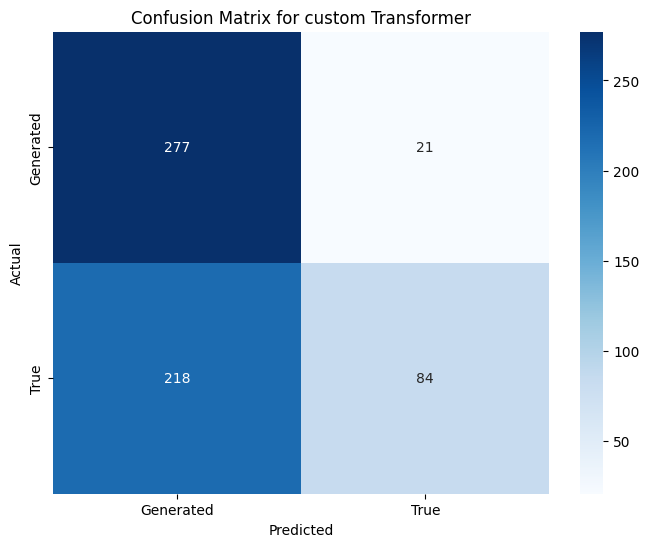

In [112]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    pd.DataFrame(cm, dtype=int),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Generated", "True"],  # data.target_names,
    yticklabels=["Generated", "True"],  # ata.target_names,
)
#ax.text(0.5, 1.5, cm[1, 0])
#ax.text(1.5, 1.5, cm[1, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for custom Transformer")
plt.show()

# Visualization

### Generation from scratch

100%|██████████| 20/20 [00:01<00:00, 19.54it/s]


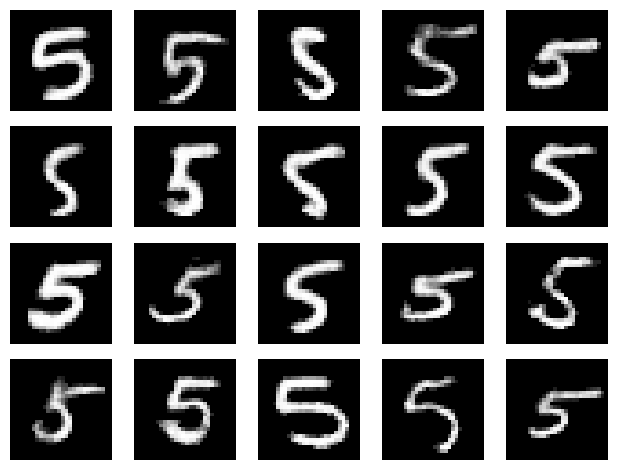

In [122]:
generated_imgs = []
num_of_images = 20
columns = 5
rows = math.ceil(num_of_images / columns)

np.random.seed(seed=20)
for i in tqdm(range(num_of_images)):
    plt.subplot(rows, columns, i + 1)
    plt.axis("off")
    img = generate_image(
        sarnet_vae,
        patch_dim,
        th = 0.105,
        latent_dim=latent_dim
    )
    generated_imgs.append(img)

plt.tight_layout()
plt.show()

### Reconstruction part of an image
Here instead of using random latent vector from $N(0,1)$, we use 
random latent vector from $N(0, (\frac{2}{3})^2)$

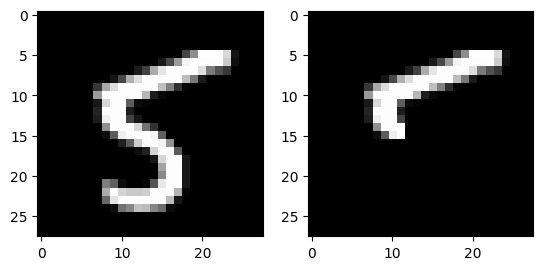

100%|██████████| 20/20 [00:00<00:00, 22.23it/s]


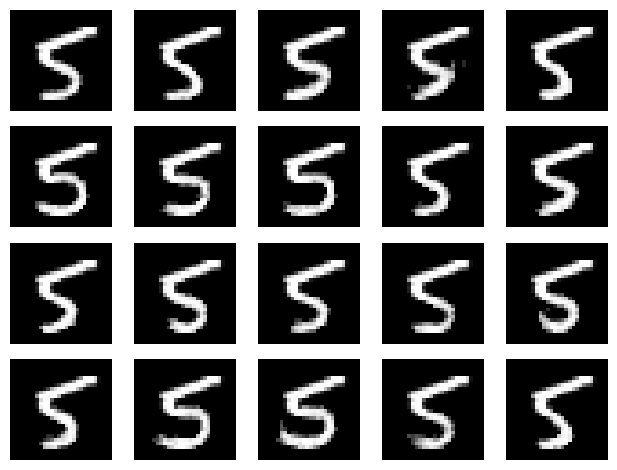

In [123]:
to_reconstruct = standarized_test_data[9]
pixels_seed = 384
plt.subplot(1, 2, 1)
plt.imshow(to_reconstruct, cmap="gray")
start_image, indexes_of_patches = init_image(
    patch_dim, to_reconstruct, pixels_seed=pixels_seed
)
plt.subplot(1, 2, 2)
plt.imshow(start_image.reshape(28, 28), cmap="gray")
plt.show()

generated_imgs = []
num_of_images = 20
columns = 5
rows = math.ceil(num_of_images / columns)

np.random.seed(seed=20)
for i in tqdm(range(num_of_images)):
    plt.subplot(rows, columns, i + 1)
    plt.axis("off")
    img = generate_image(
        sarnet_vae,
        patch_dim,
        image=standarized_test_data[9],
        th=0.15,
        pixels_seed=384,
        latent_dim=latent_dim,
        cust_z=torch.randn(1, latent_dim).to("cuda") / 1.5,
    )
    generated_imgs.append(img)

plt.tight_layout()
plt.show()